Title: Eye Disease Detection Swin-Transformer PyTorch \
Author: Bai Jie Cao, Maxine Olexa Phoa, Omole Olakunle A. \
Date created: 2023/10/13 \
Description: Image classification using Swin Transformer. \
Accelerator: GPU

This model implements [Swin Transformer: Hierarchical Vision Transformer using Shifted Windows](https://arxiv.org/abs/2103.14030)
by Liu et al. for image classification.

Swin Transformer (**S**hifted **Win**dow Transformer) can serve as a general-purpose backbone
for computer vision. Swin Transformer is a hierarchical Transformer whose
representations are computed with _shifted windows_. The shifted window scheme
brings greater efficiency by limiting self-attention computation to
non-overlapping local windows while also allowing for cross-window connections.
This architecture has the flexibility to model information at various scales and has
a linear computational complexity with respect to image size.

Code taken from [Flower Classification Swin Transformer Pytorch | Kaggle](https://www.kaggle.com/code/hamedghorbani/flower-classification-swin-transformer-pytorch/notebook) and adapted for personal use.

## 1 Initial Setup

### 1.1 Load needed packages

It is important to note that some of these packages/libraries are version dependent on which system you are running this notebook on.

In [6]:
import os
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn

from pathlib import Path
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from torch.utils.data import Dataset , DataLoader
from torchvision import transforms
from torchvision.models.swin_transformer import *
from torchvision.utils import make_grid

### 1.2 GPU setup

Use the dedicated GPU if available otherwise use CPU for the computations

In [7]:
# Setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu



## 2 Dataset

### 2.1 Loading Dataset

Load the dataset into a panda `DataFrame`.

In [8]:
path = ".\dataset"

data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)

df = pd.DataFrame(data)

Convert the labels to numbers for classification and print out the `DataFrame`.

In [9]:
# Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])

print("-------------Fetch files into a data frame-----------")
print(df)
print("-------------Path to an image file------------------")
print(df.loc[175]['imgpath'])
print("-----------Number of images per category--------------")
print(df.labels.value_counts())

-------------Fetch files into a data frame-----------
                                imgpath    labels  encoded_labels
0         .\dataset\cataract\0_left.jpg  cataract               0
1       .\dataset\cataract\103_left.jpg  cataract               0
2     .\dataset\cataract\1062_right.jpg  cataract               0
3      .\dataset\cataract\1083_left.jpg  cataract               0
4     .\dataset\cataract\1084_right.jpg  cataract               0
...                                 ...       ...             ...
4212       .\dataset\normal\8_right.jpg    normal               3
4213      .\dataset\normal\939_left.jpg    normal               3
4214     .\dataset\normal\939_right.jpg    normal               3
4215      .\dataset\normal\951_left.jpg    normal               3
4216     .\dataset\normal\951_right.jpg    normal               3

[4217 rows x 3 columns]
-------------Path to an image file------------------
.\dataset\cataract\2191_right.jpg
-----------Number of images per category--

### 2.2 Split Dataset

Split the dataset into training and validation/testing.

In [10]:
train_df, valid_df = train_test_split(df,  train_size= 0.80 , shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

print("#############Train Split###################")
print(train_df.head(5))
print(train_df.shape)
print("#############Test Split###################")
print(valid_df.head(5))
print(valid_df.shape)

#############Train Split###################
                                           imgpath                labels  \
0   .\dataset\diabetic_retinopathy\11124_left.jpeg  diabetic_retinopathy   
1   .\dataset\diabetic_retinopathy\10839_left.jpeg  diabetic_retinopathy   
2  .\dataset\diabetic_retinopathy\11545_right.jpeg  diabetic_retinopathy   
3  .\dataset\diabetic_retinopathy\11142_right.jpeg  diabetic_retinopathy   
4                   .\dataset\normal\2369_left.jpg                normal   

   encoded_labels  
0               1  
1               1  
2               1  
3               1  
4               3  
(3373, 3)
#############Test Split###################
                                           imgpath                labels  \
0  .\dataset\diabetic_retinopathy\10457_right.jpeg  diabetic_retinopathy   
1              .\dataset\glaucoma\_117_8186757.jpg              glaucoma   
2              .\dataset\glaucoma\_310_4668441.jpg              glaucoma   
3              .\datas

### 2.3 Data Augmentation

Perform needed data augmentations.

In [11]:
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),

}

### 2.4 Train and Test Dataset

Declare the `eye_Dataset` class to be used to get the images and do the needed data augmentations.

In [12]:
class eye_Dataset(Dataset):
    def __init__(self, img_data,transform=None):
        self.transform = transform
        self.img_data = img_data

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, index):
        img_name = self.img_data.loc[index]['imgpath']
        imge = Image.open(img_name)
        image = imge.resize((224,224))
        label = torch.tensor(self.img_data.loc[index]['encoded_labels'])

        if self.transform is not None:
            image = self.transform(image)

        return image, label

training_data = eye_Dataset(train_df, image_transforms['train'])
validatin_data = eye_Dataset(valid_df, image_transforms['valid'])

### 2.5 Train and Test Dataset properties

In [13]:
train_batch_size = 64
val_batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(validatin_data, batch_size=val_batch_size , shuffle=True)

print(">> Number of Train Data : {} -- Batch Size : {} -- Number of Batch : {} ".format(len(train_dataloader.dataset) , train_batch_size , len(train_dataloader)))
print(">> Number of Validiation Data : {} -- Batch Size : {} -- Number of Batch : {} ".format(len(test_dataloader.dataset) , val_batch_size , len(test_dataloader)))
onebatch = iter(train_dataloader)
train_features, train_labels = next(onebatch)
print("----------Batch Shape--------")
print(f"Feature batch shape: {train_features.size()}")
print("----------Labels Shape--------")
print(f"Labels batch shape: {train_labels.size()}")

>> Number of Train Data : 3373 -- Batch Size : 64 -- Number of Batch : 53 
>> Number of Validiation Data : 844 -- Batch Size : 64 -- Number of Batch : 14 


----------Batch Shape--------
Feature batch shape: torch.Size([64, 3, 224, 224])
----------Labels Shape--------
Labels batch shape: torch.Size([64])


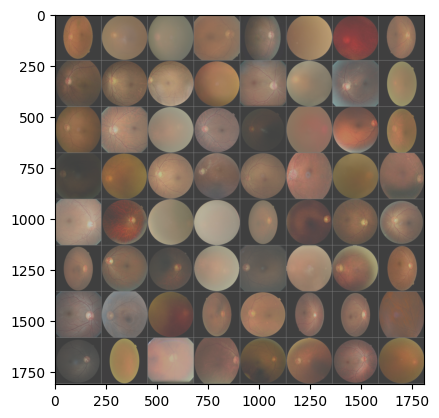

In [14]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])
def imeshow(inp):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0,2)
    plt.imshow(inp)
    plt.show()

# Get a batch of training data
inputs, classes = next(iter(test_dataloader))

# Make a grid from batch
out = make_grid(inputs)
imeshow(out)

## 3 Model

### 3.1 Model Definition

Load the pre-trained model or download the needed weights.

In [15]:
model = swin_t(weights=True)
for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.head.in_features

model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 4) #,5 for classes
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.AdamW(model.head.parameters(), lr=0.001)

c:\Users\PRABAKARAN\AppData\Local\Programs\Python\Python37\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_T_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_T_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 3.2 Training and Testing

Declare code blocks used for training and testing.

In [16]:
def train_model(model, optimizer, criterion , data_loader, device):

    model.train()
    running_loss = 0.0
    correct = 0

    for i, data in enumerate(data_loader):
        inputs , labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels = labels.to(torch.int64)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item() * inputs.size(0)

    avg_train_loss = running_loss / len(data_loader.dataset)
    avg_train_acc = ( correct / len(data_loader.dataset) ) * 100
    print(">>> Train loss {} ---- Accuracy Train {} ".format(avg_train_loss, avg_train_acc))

    return avg_train_loss , avg_train_acc

In [17]:
def test_model(model, criterion , data_loader, device):

    model.eval()

    val_loss = 0.0
    correct = 0
    all_labels = []
    all_predicted = []

    with torch.no_grad():
        for i, data in enumerate(data_loader):
            inputs , labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.to(torch.int64)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

        avg_val_acc = ( correct / len(data_loader.dataset) ) * 100
        avg_val_loss = val_loss / len(data_loader.dataset)

        f1 = f1_score(all_labels, all_predicted, average='weighted') * 100

        print(">>> Validation loss {} ---- Validation Accuracy {} ---- F1 Score {}".format(avg_val_loss, avg_val_acc, f1))

    return avg_val_loss , avg_val_acc, f1

### 3.3 Run the model

In [18]:
num_epochs = 20
history = {  "train_loss" : [] ,  "train_acc" : [] ,  "val_loss" : [] ,  "val_acc" : [], "val_f1": []}

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    T_loss , T_acc = train_model(model , optimizer , criterion, train_dataloader , device)
    V_loss , V_acc, V_f1 = test_model(model , criterion , test_dataloader, device)

    history["train_loss"].append(T_loss)
    history["train_acc"].append(T_acc)
    history["val_loss"].append(V_loss)
    history["val_acc"].append(V_acc)
    history["val_f1"].append(V_f1)

------------------ Training Epoch 1 ------------------
>>> Train loss 0.7314710581546504 ---- Accuracy Train 69.99703528016602 
>>> Validation loss 0.6225287982072876 ---- Validation Accuracy 75.9478672985782 ---- F1 Score 76.32992812750878
------------------ Training Epoch 2 ------------------
>>> Train loss 0.5558696958119601 ---- Accuracy Train 77.94248443522088 
>>> Validation loss 0.5656036223280486 ---- Validation Accuracy 78.43601895734598 ---- F1 Score 78.58897582738571
------------------ Training Epoch 3 ------------------
>>> Train loss 0.5062685445229378 ---- Accuracy Train 80.28461310406166 
>>> Validation loss 0.4873162561683293 ---- Validation Accuracy 81.27962085308057 ---- F1 Score 81.49371915130133
------------------ Training Epoch 4 ------------------
>>> Train loss 0.4951796268996237 ---- Accuracy Train 80.49214349243996 
>>> Validation loss 0.517004908261141 ---- Validation Accuracy 77.96208530805687 ---- F1 Score 77.48061566539727
------------------ Training Epoch 

### 3.4 Plot essential metrics

In [ ]:
# Define needed variables
tr_acc = history["train_acc"]
tr_loss = history["train_loss"]
val_acc = history["val_acc"]
val_loss = history["val_loss"]

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

## 4 Evaluation Metrics

In [ ]:
def evaluate_classification_metrics(all_labels, all_predicted):
    accuracy = accuracy_score(all_labels, all_predicted)
    precision = precision_score(all_labels, all_predicted, average='weighted')
    recall = recall_score(all_labels, all_predicted, average='weighted')
    f1 = f1_score(all_labels, all_predicted, average='weighted')

    cm = confusion_matrix(all_labels, all_predicted)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)

    return accuracy, precision, recall, f1, class_accuracies

def display_sample_image(model, data_loader, device, label_encoder):
    model.eval()
    sample_index = np.random.randint(len(data_loader.dataset))
    sample_image, sample_label = data_loader.dataset[sample_index]
    sample_image = sample_image.unsqueeze(0).to(device)
    model_output = model(sample_image)
    _, predicted_class = torch.max(model_output.data, 1)

    # Inverse transform predicted and true labels for display
    predicted_class = label_encoder.inverse_transform([predicted_class.item()])[0]
    true_label = label_encoder.inverse_transform([sample_label.item()])[0]

    print(f"\nSample Image:")
    imeshow(sample_image.cpu().squeeze())
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_class}")

def display_confusion_matrix(all_labels, all_predicted, label_encoder):
    cm = confusion_matrix(all_labels, all_predicted)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Usage
model.eval()
all_labels = []
all_predicted = []

with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

# Evaluate classification metrics
accuracy, precision, recall, f1, class_accuracies = evaluate_classification_metrics(all_labels, all_predicted)
print("Overall Metrics:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1 * 100:.2f}%")
print("\nAccuracy for Each Class:")
for i, class_acc in enumerate(class_accuracies):
    class_label = lb.inverse_transform([i])[0]
    print(f"{class_label}: {class_acc * 100:.2f}%")

In [ ]:
# Display a sample image and its predicted class
display_sample_image(model, test_dataloader, device, lb)

In [ ]:
# Display confusion matrix
display_confusion_matrix(all_labels, all_predicted, lb)

## 5 Saving results

In [ ]:
# Create folder with correct naming
current_date = datetime.datetime.now().strftime("%d.%m.%Y_%H.%M.%S")
folder = f"results/{current_date}_epoch={num_epochs}_f1acc={round(f1 * 100, 2)}%"
Path(folder).mkdir(exist_ok=True, parents=True)

print(f"Folder created in: {folder}")

In [ ]:
os.system(f'jupyter nbconvert --to html Eye_Disease_Detection.ipynb --output-dir={folder}')